In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

This notebook reads the data in pdiot_data/2021, removes recordings that are too small, and creates sliding windows of the recordings. These are then saved into ../data/sliding_windows_sizeX_stepX

## Getting the data

Run this for both sensors before running future notebooks.

In [2]:
data_path = '../pdiot-data/2021/'
sensor='Respeck'
# set this to 0 to produce sliding windows with no smoothing
# smoothing_window = 0
smoothing_window = 0

In [3]:
def get_base_df(sensor):
    base_df = pd.DataFrame()

    # Get a list of all respeck files in all the student folders
    all_files = []
    for f in os.listdir(data_path):
        if os.path.isdir(data_path + '/' + f):
            files = os.listdir(data_path + '/' + f)
            files = [data_path + '/' + f + '/' + f2 for f2 in files if sensor in f2]
            all_files += files
    
    # Load them all into a df
    for filename in all_files:
        #full_path = f"{clean_data_folder}/{filename}"
        #print(full_path)

        # load data into a DataFrame
        new_df = pd.read_csv(filename)

        # merge into the base DataFrame
        base_df = pd.concat([base_df, new_df])
        
    return base_df

base_df = get_base_df(sensor)

## Getting the clean data

In [4]:
clean_df = pd.read_csv(data_path + sensor + '_recordings_clean.csv')

C:\Users\Gwenyth\miniconda3\envs\pdiot\lib\site-packages\IPython\core\interactiveshell.py:3173: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
clean_df[clean_df['activity_type']=='Falling on the left'].groupby('subject_id').size()

subject_id
s2119637    765
s2171825    763
s2173036    765
dtype: int64

In [6]:
drop_indices = np.random.choice(clean_df.index, int(7*len(clean_df) / 8), replace=False)
df_subset = clean_df.drop(drop_indices)
falling_activities = ['Falling on knees', 'Falling on the back', 'Falling on the right', 'Falling on the left']
falling_non_clean = base_df[base_df['activity_type'].isin(falling_activities)]
df_subset = pd.concat([df_subset, falling_non_clean])
df_subset.to_csv(data_path + 'small_' + sensor + '_recordings_clean.csv')


In [7]:
df_subset

,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,sensor_type,activity_type,activity_code,subject_id,notes,recording_id
1,1.633516e+12,-0.177734,-0.636292,-0.477600,-5.265625,2.953125,-9.281250,Respeck,Climbing stairs,12.0,s1870467,rob,Respeck_s1870467_Climbing stairs_06-10-2021_11...
6,1.633516e+12,0.076172,-0.386780,-0.151184,-3.390625,7.578125,13.109375,Respeck,Climbing stairs,12.0,s1870467,rob,Respeck_s1870467_Climbing stairs_06-10-2021_11...
7,1.633516e+12,0.088867,-0.461243,-0.128235,-0.781250,9.875000,6.875000,Respeck,Climbing stairs,12.0,s1870467,rob,Respeck_s1870467_Climbing stairs_06-10-2021_11...
10,1.633516e+12,-0.052246,-1.419495,-0.269592,-5.437500,2.625000,-3.484375,Respeck,Climbing stairs,12.0,s1870467,rob,Respeck_s1870467_Climbing stairs_06-10-2021_11...
24,1.633516e+12,0.457031,-1.699280,0.147400,3.343750,8.562500,-15.796875,Respeck,Climbing stairs,12.0,s1870467,rob,Respeck_s1870467_Climbing stairs_06-10-2021_11...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,1.633195e+12,0.832275,-0.545227,0.698425,14.250000,-6.109375,-1.203125,Respeck,Falling on the right,46.0,s2254050,NaN,Respeck_s2254050_Falling on the right_02-10-20...
768,1.633195e+12,0.777588,-0.649719,0.831482,-4.484375,-1.828125,0.875000,Respeck,Falling on the right,46.0,s2254050,NaN,Respeck_s2254050_Falling on the right_02-10-20...
769,1.633195e+12,0.326904,-0.567932,0.676941,-14.734375,0.968750,4.765625,Respeck,Falling on the right,46.0,s2254050,NaN,Respeck_s2254050_Falling on the right_02-10-20...
770,1.633195e+12,0.362549,-0.493958,0.539001,-8.046875,1.687500,-1.687500,Respeck,Falling on the right,46.0,s2254050,NaN,Respeck_s2254050_Falling on the right_02-10-20...


In [8]:
clean_df.dtypes.apply(lambda x: x.name).to_dict()

{'timestamp': 'float64',
 'accel_x': 'float64',
 'accel_y': 'float64',
 'accel_z': 'float64',
 'gyro_x': 'float64',
 'gyro_y': 'float64',
 'gyro_z': 'float64',
 'sensor_type': 'object',
 'activity_type': 'object',
 'activity_code': 'float64',
 'subject_id': 'object',
 'notes': 'object',
 'recording_id': 'object'}

In [9]:
clean_df.groupby('activity_type').size().sort_values()

activity_type
Falling on the left         2293
Falling on the back         2307
Falling on the right        2308
Falling on knees            3830
Climbing stairs            29329
Descending stairs          30127
Running                    34530
Walking at normal speed    34616
Sitting                    35125
Sitting bent backward      35170
Sitting bent forward       35218
Standing                   35235
Desk work                  35310
Lying down right           35326
Lying down left            35380
Movement                   35381
Lying down on back         35535
Lying down on stomach      35655
dtype: int64

In [ ]:
clean_df[clean_df['activity_type'] == 'Falling on knees']['subject_id'].unique()

In [131]:
#base_df = clean_df

## Combine clean and old

In [132]:
falling_activities = ['Falling on knees', 'Falling on the back', 'Falling on the right', 'Falling on the left']
clean_non_falling = clean_df[~ clean_df['activity_type'].isin(falling_activities)]

In [133]:
falling_non_clean = base_df[base_df['activity_type'].isin(falling_activities)]

In [134]:
base_df = pd.concat([clean_non_falling, falling_non_clean])

## Cleaning

In [382]:
# We want to remove any falling recordings over 700 datapoints as this suggests that it contains falling + getting up
# We also want to remove any recordings less than the window size

In [ ]:
smallest_window_size = 25
s = base_df.groupby('recording_id').size() >= smallest_window_size

filtered_df = base_df[base_df['recording_id'].isin(s.keys()[s])]

# One Thingy recording has a bunch of NAN
filtered_df = filtered_df[filtered_df['recording_id'] != 'Thingy_s1817455_Falling on the left_29-09-2021_16-13-56']

# Remove falling recordings longer than 700
s = filtered_df[filtered_df['activity_type'].str.contains('Falling')].groupby('recording_id').size() >= 700

filtered_df = filtered_df[~filtered_df['recording_id'].isin(s.keys()[s])]

# s1702583 has really inconsistent activity naming - remove
filtered_df = filtered_df[filtered_df['subject_id'] != 's1702583']

In [ ]:
# Check that other people named correctly
filtered_df[filtered_df.apply(lambda x: not(x.activity_type in x.recording_id or x.activity_type.replace(' ', '_') in x.recording_id), axis=1)]

In [ ]:
filtered_df

In [ ]:
# drop unnecessary columns
if 'notes' in filtered_df.columns:
    filtered_df.drop(columns=['notes'], inplace=True)
if 'Unnamed: 0' in filtered_df.columns:
    filtered_df.drop(columns=['Unnamed: 0'], inplace=True)

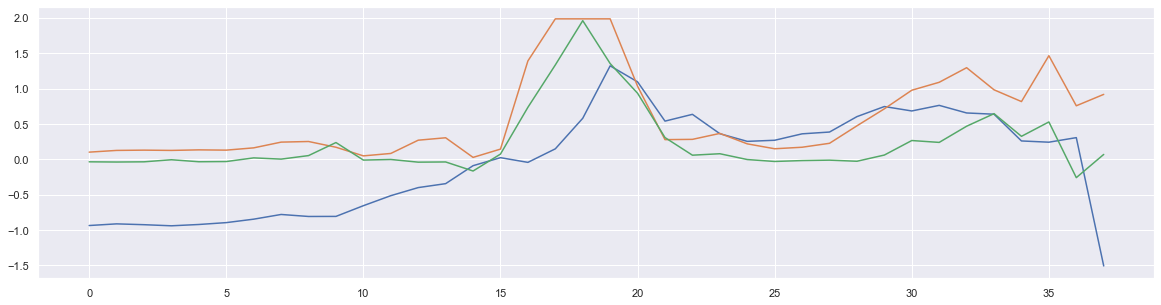

In [138]:
def plot_by_id(i): 
    plot_recording = base_df[base_df['recording_id'] == i]
    plot_recording = plot_recording.reset_index()
    plt.plot(plot_recording.index, plot_recording['accel_x'])
    plt.plot(plot_recording.index, plot_recording['accel_y'])
    plt.plot(plot_recording.index, plot_recording['accel_z'])
    
plot_by_id('Thingy_s1817455_Falling on the left_29-09-2021_16-13-56')

In [ ]:
#base_df[base_df['activity_type'] == "Falling on the back"].groupby('recording_id').size().sort_values().head(40)
#base_df.groupby('recording_id').size().sort_values().head(100)
from collections import Counter
#Counter(base_df[base_df['activity_type'] == "Falling on the back"].groupby('recording_id').size().sort_values())
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20,5)})
ax = sns.countplot(base_df[base_df['activity_type'] == "Falling on the left"].groupby('recording_id').size().sort_values())

In [ ]:
filtered_df.groupby('activity_type').size().sort_values()

## Smoothing the filtered_df

In [141]:
if smoothing_window > 0:
    smoothed_df = pd.DataFrame(columns=filtered_df.columns)
    for rec_id, group in filtered_df.groupby('recording_id'):
        win_size = smoothing_window
        win_type = 'hamming'
        center = True

        group['new_accel_x'] = group['accel_x'].rolling(window=win_size, win_type=win_type, center=center).mean()
        group['new_accel_y'] = group['accel_y'].rolling(window=win_size, win_type=win_type, center=center).mean()
        group['new_accel_z'] = group['accel_z'].rolling(window=win_size, win_type=win_type, center=center).mean()
        group['new_gyro_x'] = group['gyro_x'].rolling(window=win_size, win_type=win_type, center=center).mean()
        group['new_gyro_y'] = group['gyro_y'].rolling(window=win_size, win_type=win_type, center=center).mean()
        group['new_gyro_z'] = group['gyro_z'].rolling(window=win_size, win_type=win_type, center=center).mean()

        group.drop(columns=['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z'], inplace=True)
        group.rename(columns={'new_accel_x':'accel_x','new_accel_y':'accel_y','new_accel_z':'accel_z','new_gyro_x':'gyro_x','new_gyro_y':'gyro_y','new_gyro_z':'gyro_z' }, inplace=True)

        smoothed_df = pd.concat([smoothed_df, group], ignore_index=True)
        print(rec_id)

    # Remove any rows with NaNs (at beginning and end of recording due to smoothing)
    smoothed_df.dropna(subset=['accel_x'], inplace=True)
    smoothed_df = smoothed_df.reset_index(drop=True)

    smoothed_df

## Preparing the sliding windows

In [264]:
filtered_df['activity_type'].unique()

array(['Climbing stairs', 'Descending stairs', 'Desk work',
       'Falling on knees', 'Falling on the back', 'Falling on the left',
       'Falling on the right', 'Lying down left', 'Lying down on back',
       'Lying down on stomach', 'Lying down right', 'Movement', 'Running',
       'Sitting bent backward', 'Sitting bent forward', 'Sitting',
       'Standing', 'Walking at normal speed'], dtype=object)

In [265]:
#activities_of_interest = ['Standing', 'Walking at normal speed']
activities_of_interest = filtered_df['activity_type'].unique()

In [266]:
def get_overlapping_windows(df, window_size, step_size):
    window_number = 0 # start a counter at 0 to keep track of the window number

    all_overlapping_windows = []

    for rid, group in df.groupby("recording_id"):
        if group['activity_type'].iloc[0] in activities_of_interest:

            print(f"Processing rid = {rid}")

            large_enough_windows = [window for window in group.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]

            overlapping_windows = large_enough_windows[::step_size] 

            # then we will append a window ID to each window
            for i, window in enumerate(overlapping_windows):
                #print(type(window))
                #window['window_id'] = np.repeat(window_number, len(window))
                overlapping_windows[i].insert(1, "window_id", window_number)
                #window.loc[:, 'window_id'] = window_number
                window_number += 1

            #print(overlapping_windows)

            if len(overlapping_windows) != 0:
                all_overlapping_windows.append(pd.concat(overlapping_windows).reset_index(drop=True))
    return all_overlapping_windows

window_size = smallest_window_size 
step_size = smallest_window_size

if smoothing_window > 0:
    # with smoothing
    all_overlapping_windows = get_overlapping_windows(smoothed_df, window_size, step_size)
else:
    # no smoothing
    all_overlapping_windows = get_overlapping_windows(filtered_df, window_size, step_size)



Processing rid = Respeck_s1541031_Climbing stairs_06-10-2021_11-25-43
Processing rid = Respeck_s1541031_Descending stairs_06-10-2021_11-25-05
Processing rid = Respeck_s1541031_Desk work_06-10-2021_11-04-49
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-46-44
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-02
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-13
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-20
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-25
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-30
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-35
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-39
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-44
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-48
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-52
Processing ri

Processing rid = Respeck_s1704145_Lying down on back_23-09-2021_11-42-59
Processing rid = Respeck_s1704145_Lying down on stomach_05-10-2021_18-36-31
Processing rid = Respeck_s1704145_Lying down right_23-09-2021_11-41-34
Processing rid = Respeck_s1704145_Movement_23-09-2021_11-45-40
Processing rid = Respeck_s1704145_Running_23-09-2021_11-31-45
Processing rid = Respeck_s1704145_Sitting bent backward_23-09-2021_11-39-14
Processing rid = Respeck_s1704145_Sitting bent forward_23-09-2021_11-38-32
Processing rid = Respeck_s1704145_Sitting_23-09-2021_11-37-46
Processing rid = Respeck_s1704145_Standing_23-09-2021_11-40-05
Processing rid = Respeck_s1704145_Walking at normal speed_23-09-2021_11-32-29
Processing rid = Respeck_s1706154_Climbing stairs_05-10-2021_12-30-49
Processing rid = Respeck_s1706154_Descending stairs_05-10-2021_12-31-30
Processing rid = Respeck_s1706154_Desk work_05-10-2021_12-33-00
Processing rid = Respeck_s1706154_Falling on knees_06-10-2021_12-38-48
Processing rid = Respeck

Processing rid = Respeck_s1711661_Falling on the back_24-09-2021_21-51-49
Processing rid = Respeck_s1711661_Falling on the back_24-09-2021_21-51-57
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-38-30
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-38-35
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-38-41
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-38-47
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-38-52
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-38-57
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-39-03
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-39-10
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-39-16
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-39-21
Processing rid = Respeck_s1711661_Falling on the left_24-09-2021_21-39-30
Processing rid = Respeck_s1711661_Fall

Processing rid = Respeck_s1721256_Lying down on back_01-10-2021_19-03-04
Processing rid = Respeck_s1721256_Lying down on stomach_01-10-2021_19-06-05
Processing rid = Respeck_s1721256_Lying down right_01-10-2021_19-07-30
Processing rid = Respeck_s1721256_Movement_01-10-2021_20-07-39
Processing rid = Respeck_s1721256_Running_02-10-2021_17-26-10
Processing rid = Respeck_s1721256_Sitting bent backward_02-10-2021_17-39-15
Processing rid = Respeck_s1721256_Sitting bent forward_01-10-2021_18-46-19
Processing rid = Respeck_s1721256_Sitting_01-10-2021_18-42-57
Processing rid = Respeck_s1721256_Standing_01-10-2021_19-00-30
Processing rid = Respeck_s1721256_Walking at normal speed_02-10-2021_22-12-45
Processing rid = Respeck_s1724067_Climbing stairs_06-10-2021_19-40-23
Processing rid = Respeck_s1724067_Climbing stairs_06-10-2021_19-40-35
Processing rid = Respeck_s1724067_Climbing stairs_06-10-2021_19-40-51
Processing rid = Respeck_s1724067_Climbing stairs_06-10-2021_19-41-02
Processing rid = Resp

Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-54-23
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-54-30
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-54-39
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-54-47
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-55-06
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-55-18
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-55-30
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-55-40
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-56-02
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-56-12
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-56-20
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-56-28
Processing rid = Respeck_s1724067_Falling on the right_06-10-2021_18-56-44
Processing rid = Respeck_

Processing rid = Respeck_s1727780_Falling on knees_29-09-2021_21-59-46
Processing rid = Respeck_s1727780_Falling on knees_29-09-2021_21-59-55
Processing rid = Respeck_s1727780_Falling on knees_29-09-2021_22-00-05
Processing rid = Respeck_s1727780_Falling on knees_29-09-2021_22-00-18
Processing rid = Respeck_s1727780_Falling on knees_29-09-2021_22-00-30
Processing rid = Respeck_s1727780_Falling on knees_29-09-2021_22-00-39
Processing rid = Respeck_s1727780_Falling on knees_29-09-2021_22-00-47
Processing rid = Respeck_s1727780_Falling on knees_29-09-2021_22-00-56
Processing rid = Respeck_s1727780_Falling on the back_29-09-2021_21-48-53
Processing rid = Respeck_s1727780_Falling on the back_29-09-2021_21-49-03
Processing rid = Respeck_s1727780_Falling on the back_29-09-2021_21-49-13
Processing rid = Respeck_s1727780_Falling on the back_29-09-2021_21-49-22
Processing rid = Respeck_s1727780_Falling on the back_29-09-2021_21-49-31
Processing rid = Respeck_s1727780_Falling on the back_29-09-20

Processing rid = Respeck_s1732873_Falling on the right_04-10-2021_13-12-57
Processing rid = Respeck_s1732873_Falling on the right_04-10-2021_13-13-23
Processing rid = Respeck_s1732873_Falling on the right_04-10-2021_13-13-31
Processing rid = Respeck_s1732873_Falling on the right_04-10-2021_13-13-39
Processing rid = Respeck_s1732873_Falling on the right_04-10-2021_13-13-50
Processing rid = Respeck_s1732873_Falling on the right_04-10-2021_13-13-56
Processing rid = Respeck_s1732873_Falling on the right_04-10-2021_13-14-04
Processing rid = Respeck_s1732873_Falling on the right_04-10-2021_13-14-11
Processing rid = Respeck_s1732873_Falling on the right_04-10-2021_13-14-19
Processing rid = Respeck_s1732873_Falling on the right_04-10-2021_13-14-27
Processing rid = Respeck_s1732873_Falling on the right_04-10-2021_13-14-34
Processing rid = Respeck_s1732873_Falling on the right_04-10-2021_13-14-49
Processing rid = Respeck_s1732873_Falling on the right_04-10-2021_13-14-59
Processing rid = Respeck_

Processing rid = Respeck_s1761322_Falling on the left_06-10-2021_12-59-21
Processing rid = Respeck_s1761322_Falling on the left_06-10-2021_12-59-30
Processing rid = Respeck_s1761322_Falling on the left_06-10-2021_12-59-38
Processing rid = Respeck_s1761322_Falling on the left_06-10-2021_12-59-45
Processing rid = Respeck_s1761322_Falling on the left_06-10-2021_12-59-53
Processing rid = Respeck_s1761322_Falling on the left_06-10-2021_13-00-01
Processing rid = Respeck_s1761322_Falling on the left_06-10-2021_13-00-12
Processing rid = Respeck_s1761322_Falling on the left_06-10-2021_13-00-23
Processing rid = Respeck_s1761322_Falling on the left_06-10-2021_13-00-31
Processing rid = Respeck_s1761322_Falling on the left_06-10-2021_13-00-41
Processing rid = Respeck_s1761322_Falling on the left_06-10-2021_13-00-48
Processing rid = Respeck_s1761322_Falling on the left_06-10-2021_13-00-57
Processing rid = Respeck_s1761322_Falling on the left_06-10-2021_13-01-04
Processing rid = Respeck_s1761322_Fall

Processing rid = Respeck_s1801931_Descending stairs_06-10-2021_00-21-24
Processing rid = Respeck_s1801931_Desk work_05-10-2021_23-13-57
Processing rid = Respeck_s1801931_Falling on knees_05-10-2021_23-21-43
Processing rid = Respeck_s1801931_Falling on knees_05-10-2021_23-21-47
Processing rid = Respeck_s1801931_Falling on knees_05-10-2021_23-21-52
Processing rid = Respeck_s1801931_Falling on knees_05-10-2021_23-21-57
Processing rid = Respeck_s1801931_Falling on knees_05-10-2021_23-22-02
Processing rid = Respeck_s1801931_Falling on knees_05-10-2021_23-22-07
Processing rid = Respeck_s1801931_Falling on knees_05-10-2021_23-22-12
Processing rid = Respeck_s1801931_Falling on knees_05-10-2021_23-22-17
Processing rid = Respeck_s1801931_Falling on knees_05-10-2021_23-22-23
Processing rid = Respeck_s1801931_Falling on knees_05-10-2021_23-22-28
Processing rid = Respeck_s1801931_Falling on knees_05-10-2021_23-22-33
Processing rid = Respeck_s1801931_Falling on knees_05-10-2021_23-22-39
Processing r

Processing rid = Respeck_s1813106_Falling on the left_07-10-2021_13-24-51
Processing rid = Respeck_s1813106_Falling on the left_07-10-2021_13-25-06
Processing rid = Respeck_s1813106_Falling on the left_07-10-2021_13-25-16
Processing rid = Respeck_s1813106_Falling on the left_07-10-2021_13-25-22
Processing rid = Respeck_s1813106_Falling on the left_07-10-2021_13-25-32
Processing rid = Respeck_s1813106_Falling on the left_07-10-2021_13-25-37
Processing rid = Respeck_s1813106_Falling on the left_07-10-2021_13-25-42
Processing rid = Respeck_s1813106_Falling on the right_07-10-2021_13-19-58
Processing rid = Respeck_s1813106_Falling on the right_07-10-2021_13-20-04
Processing rid = Respeck_s1813106_Falling on the right_07-10-2021_13-20-09
Processing rid = Respeck_s1813106_Falling on the right_07-10-2021_13-20-19
Processing rid = Respeck_s1813106_Falling on the right_07-10-2021_13-20-26
Processing rid = Respeck_s1813106_Falling on the right_07-10-2021_13-20-30
Processing rid = Respeck_s181310

Processing rid = Respeck_s1817455_Lying down right_29-09-2021_14-40-25
Processing rid = Respeck_s1817455_Movement_29-09-2021_14-48-46
Processing rid = Respeck_s1817455_Running_29-09-2021_14-57-36
Processing rid = Respeck_s1817455_Sitting bent backward_29-09-2021_14-24-39
Processing rid = Respeck_s1817455_Sitting bent forward_29-09-2021_14-22-39
Processing rid = Respeck_s1817455_Sitting_29-09-2021_14-19-52
Processing rid = Respeck_s1817455_Standing_29-09-2021_14-26-43
Processing rid = Respeck_s1817455_Walking at normal speed_29-09-2021_14-54-19
Processing rid = Respeck_s1817972_Climbing stairs_05-10-2021_14-15-10
Processing rid = Respeck_s1817972_Descending stairs_05-10-2021_14-14-27
Processing rid = Respeck_s1817972_Desk work_05-10-2021_11-25-28
Processing rid = Respeck_s1817972_Falling on knees_05-10-2021_11-27-06
Processing rid = Respeck_s1817972_Falling on knees_05-10-2021_11-27-10
Processing rid = Respeck_s1817972_Falling on knees_05-10-2021_11-27-14
Processing rid = Respeck_s18179

Processing rid = Respeck_s1822958_Falling on the back_29-09-2021_16-35-12
Processing rid = Respeck_s1822958_Falling on the back_29-09-2021_16-35-18
Processing rid = Respeck_s1822958_Falling on the back_29-09-2021_16-35-23
Processing rid = Respeck_s1822958_Falling on the back_29-09-2021_16-35-29
Processing rid = Respeck_s1822958_Falling on the back_29-09-2021_16-35-41
Processing rid = Respeck_s1822958_Falling on the back_29-09-2021_16-35-46
Processing rid = Respeck_s1822958_Falling on the back_29-09-2021_16-35-52
Processing rid = Respeck_s1822958_Falling on the back_29-09-2021_16-35-57
Processing rid = Respeck_s1822958_Falling on the back_29-09-2021_16-36-03
Processing rid = Respeck_s1822958_Falling on the back_29-09-2021_16-36-06
Processing rid = Respeck_s1822958_Falling on the left_29-09-2021_16-38-48
Processing rid = Respeck_s1822958_Falling on the left_29-09-2021_16-38-53
Processing rid = Respeck_s1822958_Falling on the left_29-09-2021_16-38-58
Processing rid = Respeck_s1822958_Fall

Processing rid = Respeck_s1823274_Walking at normal speed_29-09-2021_12-30-31
Processing rid = Respeck_s1824891_Climbing stairs_06-10-2021_17-03-00
Processing rid = Respeck_s1824891_Descending stairs_06-10-2021_17-01-27
Processing rid = Respeck_s1824891_Desk work_06-10-2021_16-55-14
Processing rid = Respeck_s1824891_Falling on knees_06-10-2021_21-38-24
Processing rid = Respeck_s1824891_Falling on knees_06-10-2021_21-38-32
Processing rid = Respeck_s1824891_Falling on knees_06-10-2021_21-38-36
Processing rid = Respeck_s1824891_Falling on knees_06-10-2021_21-38-40
Processing rid = Respeck_s1824891_Falling on knees_06-10-2021_21-38-44
Processing rid = Respeck_s1824891_Falling on knees_06-10-2021_21-38-52
Processing rid = Respeck_s1824891_Falling on knees_06-10-2021_21-38-56
Processing rid = Respeck_s1824891_Falling on knees_06-10-2021_21-39-00
Processing rid = Respeck_s1824891_Falling on knees_06-10-2021_21-39-03
Processing rid = Respeck_s1824891_Falling on knees_06-10-2021_21-39-07
Proces

Processing rid = Respeck_s1826390_Falling on the left_08-10-2021_00-29-59
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-53-15
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-53-26
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-54-23
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-54-34
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-54-41
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-54-45
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-54-52
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-54-57
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-55-03
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-55-14
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-55-39
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-55-46
Processing rid = Respeck_s

Processing rid = Respeck_s1842093_Falling on the left_05-10-2021_20-30-16
Processing rid = Respeck_s1842093_Falling on the left_05-10-2021_20-30-37
Processing rid = Respeck_s1842093_Falling on the left_05-10-2021_20-30-47
Processing rid = Respeck_s1842093_Falling on the left_05-10-2021_20-30-54
Processing rid = Respeck_s1842093_Falling on the left_05-10-2021_20-31-15
Processing rid = Respeck_s1842093_Falling on the left_05-10-2021_20-31-54
Processing rid = Respeck_s1842093_Falling on the left_05-10-2021_20-32-00
Processing rid = Respeck_s1842093_Falling on the left_05-10-2021_20-32-14
Processing rid = Respeck_s1842093_Falling on the left_05-10-2021_20-32-20
Processing rid = Respeck_s1842093_Falling on the right_05-10-2021_21-30-33
Processing rid = Respeck_s1842093_Falling on the right_05-10-2021_21-30-59
Processing rid = Respeck_s1842093_Falling on the right_05-10-2021_21-31-14
Processing rid = Respeck_s1842093_Falling on the right_05-10-2021_21-31-21
Processing rid = Respeck_s1842093_

Processing rid = Respeck_s1850642_Falling on the back_06-10-2021_13-06-19
Processing rid = Respeck_s1850642_Falling on the back_06-10-2021_13-06-23
Processing rid = Respeck_s1850642_Falling on the back_06-10-2021_13-06-27
Processing rid = Respeck_s1850642_Falling on the back_06-10-2021_13-06-31
Processing rid = Respeck_s1850642_Falling on the back_06-10-2021_13-06-35
Processing rid = Respeck_s1850642_Falling on the left_06-10-2021_13-00-12
Processing rid = Respeck_s1850642_Falling on the left_06-10-2021_13-00-16
Processing rid = Respeck_s1850642_Falling on the left_06-10-2021_13-00-30
Processing rid = Respeck_s1850642_Falling on the left_06-10-2021_13-00-34
Processing rid = Respeck_s1850642_Falling on the left_06-10-2021_13-00-38
Processing rid = Respeck_s1850642_Falling on the left_06-10-2021_13-00-42
Processing rid = Respeck_s1850642_Falling on the left_06-10-2021_13-00-46
Processing rid = Respeck_s1850642_Falling on the left_06-10-2021_13-00-51
Processing rid = Respeck_s1850642_Fall

Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-22-38
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-22-49
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-28-01
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-28-06
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-28-18
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-28-23
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-28-27
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-28-32
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-28-37
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-28-47
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-28-52
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-28-57
Processing rid = Respeck_s1864705_Falling on the right_06-10-2021_23-29-02
Processing rid = Respeck_

Processing rid = Respeck_s1865890_Falling on the back_05-10-2021_18-34-42
Processing rid = Respeck_s1865890_Falling on the back_05-10-2021_18-34-49
Processing rid = Respeck_s1865890_Falling on the back_05-10-2021_18-34-53
Processing rid = Respeck_s1865890_Falling on the back_05-10-2021_18-34-59
Processing rid = Respeck_s1865890_Falling on the back_05-10-2021_18-35-06
Processing rid = Respeck_s1865890_Falling on the back_05-10-2021_18-35-12
Processing rid = Respeck_s1865890_Falling on the back_05-10-2021_18-35-18
Processing rid = Respeck_s1865890_Falling on the back_05-10-2021_18-35-23
Processing rid = Respeck_s1865890_Falling on the back_05-10-2021_18-35-29
Processing rid = Respeck_s1865890_Falling on the left_05-10-2021_18-51-26
Processing rid = Respeck_s1865890_Falling on the left_05-10-2021_18-51-36
Processing rid = Respeck_s1865890_Falling on the left_05-10-2021_18-51-46
Processing rid = Respeck_s1865890_Falling on the left_05-10-2021_18-51-55
Processing rid = Respeck_s1865890_Fall

Processing rid = Respeck_s1870697_Falling on the left_04-10-2021_18-13-57
Processing rid = Respeck_s1870697_Falling on the left_04-10-2021_18-14-07
Processing rid = Respeck_s1870697_Falling on the left_04-10-2021_18-14-15
Processing rid = Respeck_s1870697_Falling on the left_04-10-2021_18-14-28
Processing rid = Respeck_s1870697_Falling on the left_04-10-2021_18-14-36
Processing rid = Respeck_s1870697_Falling on the left_04-10-2021_18-14-59
Processing rid = Respeck_s1870697_Falling on the left_04-10-2021_18-15-06
Processing rid = Respeck_s1870697_Falling on the left_04-10-2021_18-15-27
Processing rid = Respeck_s1870697_Falling on the left_04-10-2021_18-15-41
Processing rid = Respeck_s1870697_Falling on the left_04-10-2021_18-15-56
Processing rid = Respeck_s1870697_Falling on the left_04-10-2021_18-16-19
Processing rid = Respeck_s1870697_Falling on the left_04-10-2021_18-16-32
Processing rid = Respeck_s1870697_Falling on the left_06-10-2021_09-00-36
Processing rid = Respeck_s1870697_Fall

Processing rid = Respeck_s1891214_Lying down on stomach_07-10-2021_14-21-21
Processing rid = Respeck_s1891214_Lying down right_07-10-2021_14-20-40
Processing rid = Respeck_s1891214_Movement_07-10-2021_14-26-13
Processing rid = Respeck_s1891214_Running_07-10-2021_14-23-03
Processing rid = Respeck_s1891214_Sitting bent backward_07-10-2021_14-17-22
Processing rid = Respeck_s1891214_Sitting bent forward_07-10-2021_14-16-44
Processing rid = Respeck_s1891214_Sitting_07-10-2021_14-15-48
Processing rid = Respeck_s1891214_Standing_07-10-2021_14-18-00
Processing rid = Respeck_s1891214_Walking at normal speed_07-10-2021_14-22-14
Processing rid = Respeck_s1893474_Climbing stairs_07-10-2021_21-05-25
Processing rid = Respeck_s1893474_Descending stairs_07-10-2021_21-06-16
Processing rid = Respeck_s1893474_Desk work_04-10-2021_01-53-44
Processing rid = Respeck_s1893474_Falling on knees_03-10-2021_17-15-53
Processing rid = Respeck_s1893474_Falling on knees_03-10-2021_17-16-04
Processing rid = Respeck_s

Processing rid = Respeck_s1894401_Falling on the left_01-10-2021_11-55-13
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-50-38
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-50-45
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-50-59
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-51-05
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-51-10
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-51-19
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-51-29
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-51-36
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-51-43
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-51-51
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-51-57
Processing rid = Respeck_s1894401_Lying down left_01-10-2021_12-03-57
Processing rid = Respeck_s18944

Processing rid = Respeck_s2119637_Falling on knees_06-10-2021_14-45-52
Processing rid = Respeck_s2119637_Falling on knees_06-10-2021_14-45-57
Processing rid = Respeck_s2119637_Falling on knees_06-10-2021_14-46-04
Processing rid = Respeck_s2119637_Falling on knees_06-10-2021_14-46-11
Processing rid = Respeck_s2119637_Falling on the back_03-10-2021_23-30-35
Processing rid = Respeck_s2119637_Falling on the back_06-10-2021_15-06-46
Processing rid = Respeck_s2119637_Falling on the back_06-10-2021_15-06-52
Processing rid = Respeck_s2119637_Falling on the back_06-10-2021_15-06-58
Processing rid = Respeck_s2119637_Falling on the back_06-10-2021_15-07-14
Processing rid = Respeck_s2119637_Falling on the back_06-10-2021_15-07-32
Processing rid = Respeck_s2119637_Falling on the back_06-10-2021_15-07-40
Processing rid = Respeck_s2119637_Falling on the back_06-10-2021_15-07-48
Processing rid = Respeck_s2119637_Falling on the back_06-10-2021_15-08-07
Processing rid = Respeck_s2119637_Falling on the b

Processing rid = Respeck_s2125423_Falling on the right_03-10-2021_16-29-21
Processing rid = Respeck_s2125423_Falling on the right_03-10-2021_16-29-37
Processing rid = Respeck_s2125423_Falling on the right_03-10-2021_16-30-05
Processing rid = Respeck_s2125423_Falling on the right_03-10-2021_16-30-15
Processing rid = Respeck_s2125423_Falling on the right_03-10-2021_16-30-28
Processing rid = Respeck_s2125423_Falling on the right_03-10-2021_16-30-45
Processing rid = Respeck_s2125423_Falling on the right_03-10-2021_16-30-55
Processing rid = Respeck_s2125423_Lying down left_03-10-2021_15-55-43
Processing rid = Respeck_s2125423_Lying down on back_03-10-2021_15-59-06
Processing rid = Respeck_s2125423_Lying down on stomach_03-10-2021_16-01-39
Processing rid = Respeck_s2125423_Lying down right_03-10-2021_15-57-27
Processing rid = Respeck_s2125423_Movement_03-10-2021_16-04-42
Processing rid = Respeck_s2125423_Running_03-10-2021_17-35-53
Processing rid = Respeck_s2125423_Sitting bent backward_03-1

Processing rid = Respeck_s2171931_Falling on the back_04-10-2021_16-16-06
Processing rid = Respeck_s2171931_Falling on the back_04-10-2021_16-16-17
Processing rid = Respeck_s2171931_Falling on the left_04-10-2021_16-09-50
Processing rid = Respeck_s2171931_Falling on the left_04-10-2021_16-10-00
Processing rid = Respeck_s2171931_Falling on the left_04-10-2021_16-10-12
Processing rid = Respeck_s2171931_Falling on the left_04-10-2021_16-10-22
Processing rid = Respeck_s2171931_Falling on the left_04-10-2021_16-10-34
Processing rid = Respeck_s2171931_Falling on the left_04-10-2021_16-10-45
Processing rid = Respeck_s2171931_Falling on the left_04-10-2021_16-10-56
Processing rid = Respeck_s2171931_Falling on the left_04-10-2021_16-11-08
Processing rid = Respeck_s2171931_Falling on the left_04-10-2021_16-11-19
Processing rid = Respeck_s2171931_Falling on the left_04-10-2021_16-11-30
Processing rid = Respeck_s2171931_Falling on the right_04-10-2021_16-12-12
Processing rid = Respeck_s2171931_Fal

Processing rid = Respeck_s2181154_Descending stairs_03-10-2021_17-46-42
Processing rid = Respeck_s2181154_Desk work_03-10-2021_17-48-15
Processing rid = Respeck_s2181154_Falling on knees_07-10-2021_19-06-28
Processing rid = Respeck_s2181154_Falling on knees_07-10-2021_19-06-35
Processing rid = Respeck_s2181154_Falling on knees_07-10-2021_19-06-40
Processing rid = Respeck_s2181154_Falling on knees_07-10-2021_19-06-45
Processing rid = Respeck_s2181154_Falling on knees_07-10-2021_19-06-51
Processing rid = Respeck_s2181154_Falling on knees_07-10-2021_19-06-56
Processing rid = Respeck_s2181154_Falling on knees_07-10-2021_19-07-01
Processing rid = Respeck_s2181154_Falling on knees_07-10-2021_19-07-06
Processing rid = Respeck_s2181154_Falling on knees_07-10-2021_19-07-16
Processing rid = Respeck_s2181154_Falling on knees_07-10-2021_19-07-55
Processing rid = Respeck_s2181154_Falling on knees_07-10-2021_19-08-00
Processing rid = Respeck_s2181154_Falling on knees_07-10-2021_19-08-05
Processing r

Processing rid = Respeck_s2192970_Falling on the left_06-10-2021_21-03-09
Processing rid = Respeck_s2192970_Falling on the left_06-10-2021_21-03-16
Processing rid = Respeck_s2192970_Falling on the left_06-10-2021_21-03-22
Processing rid = Respeck_s2192970_Falling on the left_06-10-2021_21-03-28
Processing rid = Respeck_s2192970_Falling on the left_06-10-2021_21-03-37
Processing rid = Respeck_s2192970_Falling on the left_06-10-2021_21-03-44
Processing rid = Respeck_s2192970_Falling on the left_06-10-2021_21-04-09
Processing rid = Respeck_s2192970_Falling on the left_06-10-2021_21-04-21
Processing rid = Respeck_s2192970_Falling on the left_06-10-2021_21-04-27
Processing rid = Respeck_s2192970_Falling on the left_06-10-2021_21-04-33
Processing rid = Respeck_s2192970_Falling on the left_06-10-2021_21-04-40
Processing rid = Respeck_s2192970_Falling on the left_06-10-2021_21-04-48
Processing rid = Respeck_s2192970_Falling on the left_06-10-2021_22-33-53
Processing rid = Respeck_s2192970_Fall

Processing rid = Respeck_s2211162_Lying down on stomach_28-09-2021_10-31-36
Processing rid = Respeck_s2211162_Lying down right_28-09-2021_10-29-37
Processing rid = Respeck_s2211162_Movement_28-09-2021_10-39-45
Processing rid = Respeck_s2211162_Running_28-09-2021_11-19-48
Processing rid = Respeck_s2211162_Sitting bent backward_28-09-2021_10-25-32
Processing rid = Respeck_s2211162_Sitting bent forward_28-09-2021_10-23-12
Processing rid = Respeck_s2211162_Sitting_28-09-2021_10-22-16
Processing rid = Respeck_s2211162_Standing_28-09-2021_10-26-50
Processing rid = Respeck_s2211162_Walking at normal speed_28-09-2021_11-03-08
Processing rid = Respeck_s2211228_Climbing stairs_07-10-2021_23-20-09
Processing rid = Respeck_s2211228_Descending stairs_07-10-2021_23-20-57
Processing rid = Respeck_s2211228_Desk work_06-10-2021_19-40-26
Processing rid = Respeck_s2211228_Falling on knees_06-10-2021_19-52-26
Processing rid = Respeck_s2211228_Falling on knees_06-10-2021_19-52-30
Processing rid = Respeck_s

Processing rid = Respeck_s2211228_Falling on the right_06-10-2021_23-53-33
Processing rid = Respeck_s2211228_Falling on the right_06-10-2021_23-54-04
Processing rid = Respeck_s2211228_Falling on the right_06-10-2021_23-54-15
Processing rid = Respeck_s2211228_Lying down left_06-10-2021_19-44-52
Processing rid = Respeck_s2211228_Lying down on back_29-09-2021_16-35-03
Processing rid = Respeck_s2211228_Lying down on stomach_29-09-2021_16-39-53
Processing rid = Respeck_s2211228_Lying down right_06-10-2021_23-57-34
Processing rid = Respeck_s2211228_Movement_06-10-2021_19-49-33
Processing rid = Respeck_s2211228_Running_29-09-2021_18-21-08
Processing rid = Respeck_s2211228_Sitting bent backward_29-09-2021_16-32-47
Processing rid = Respeck_s2211228_Sitting bent forward_06-10-2021_16-35-38
Processing rid = Respeck_s2211228_Sitting_06-10-2021_16-29-47
Processing rid = Respeck_s2211228_Standing_06-10-2021_19-41-22
Processing rid = Respeck_s2211228_Walking at normal speed_06-10-2021_19-48-09
Proces

Processing rid = Respeck_s2250677_Falling on the right_04-10-2021_16-57-23
Processing rid = Respeck_s2250677_Falling on the right_04-10-2021_16-57-31
Processing rid = Respeck_s2250677_Falling on the right_04-10-2021_16-57-39
Processing rid = Respeck_s2250677_Lying down left_04-10-2021_16-13-38
Processing rid = Respeck_s2250677_Lying down on back_04-10-2021_16-11-56
Processing rid = Respeck_s2250677_Lying down on stomach_04-10-2021_16-16-54
Processing rid = Respeck_s2250677_Lying down right_04-10-2021_16-14-52
Processing rid = Respeck_s2250677_Movement_04-10-2021_16-30-39
Processing rid = Respeck_s2250677_Running_04-10-2021_16-21-45
Processing rid = Respeck_s2250677_Sitting bent backward_04-10-2021_16-08-21
Processing rid = Respeck_s2250677_Sitting bent forward_04-10-2021_16-07-07
Processing rid = Respeck_s2250677_Sitting_04-10-2021_16-06-14
Processing rid = Respeck_s2250677_Standing_04-10-2021_16-09-34
Processing rid = Respeck_s2250677_Walking at normal speed_04-10-2021_16-20-14
Proces

In [267]:
all_overlapping_windows[0]

,timestamp,window_id,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,sensor_type,activity_type,activity_code,subject_id,recording_id
0,1.633516e+12,0,-0.763184,-0.014465,0.079773,22.062500,9.484375,15.671875,Respeck,Climbing stairs,12.0,s1541031,Respeck_s1541031_Climbing stairs_06-10-2021_11...
1,1.633516e+12,0,-0.794678,0.042175,0.153503,7.578125,-11.687500,6.468750,Respeck,Climbing stairs,12.0,s1541031,Respeck_s1541031_Climbing stairs_06-10-2021_11...
2,1.633516e+12,0,-0.748291,-0.076233,0.016296,15.781250,-9.375000,4.890625,Respeck,Climbing stairs,12.0,s1541031,Respeck_s1541031_Climbing stairs_06-10-2021_11...
3,1.633516e+12,0,-0.949707,-0.011536,0.012390,6.046875,-7.031250,1.531250,Respeck,Climbing stairs,12.0,s1541031,Respeck_s1541031_Climbing stairs_06-10-2021_11...
4,1.633516e+12,0,-1.209961,0.216492,0.016296,-19.218750,-6.078125,1.421875,Respeck,Climbing stairs,12.0,s1541031,Respeck_s1541031_Climbing stairs_06-10-2021_11...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,1.633516e+12,29,-0.656982,0.154968,0.040466,-10.343750,7.015625,-15.453125,Respeck,Climbing stairs,12.0,s1541031,Respeck_s1541031_Climbing stairs_06-10-2021_11...
746,1.633516e+12,29,-1.168457,0.224548,0.094910,9.812500,-0.484375,-26.375000,Respeck,Climbing stairs,12.0,s1541031,Respeck_s1541031_Climbing stairs_06-10-2021_11...
747,1.633516e+12,29,-1.047363,0.302185,0.026062,18.375000,-22.640625,-13.609375,Respeck,Climbing stairs,12.0,s1541031,Respeck_s1541031_Climbing stairs_06-10-2021_11...
748,1.633516e+12,29,-0.945801,0.244812,-0.166565,4.453125,14.359375,0.359375,Respeck,Climbing stairs,12.0,s1541031,Respeck_s1541031_Climbing stairs_06-10-2021_11...


In [268]:
final_sliding_windows = pd.concat(all_overlapping_windows).reset_index(drop=True)

In [269]:
len(final_sliding_windows)

607000

In [270]:
# Remove any sliding windows that have NaNs in recording data
s = final_sliding_windows[final_sliding_windows.isnull().sum(axis=1)>0]['window_id']
final_sliding_windows = final_sliding_windows[~final_sliding_windows['window_id'].isin(s)]

In [271]:
final_sliding_windows.groupby('window_id').size().sort_values().tail(2)

window_id
8095     25
24279    25
dtype: int64

In [272]:
final_sliding_windows.groupby('activity_type').size().sort_values()

activity_type
Falling on knees           27725
Falling on the left        27800
Falling on the right       27925
Falling on the back        27925
Climbing stairs            34650
Running                    34825
Walking at normal speed    34900
Descending stairs          35350
Sitting                    35375
Sitting bent backward      35400
Sitting bent forward       35450
Standing                   35500
Lying down right           35600
Desk work                  35600
Lying down left            35650
Movement                   35650
Lying down on stomach      35825
Lying down on back         35825
dtype: int64

In [273]:
final_sliding_windows.to_csv('../data/latest_sliding_windows_' + sensor + '_smooth' + str(smoothing_window) + '_smallest' + str(smallest_window_size) + '_size'+ str(window_size) + '_step' + str(step_size) + '.csv')